In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

In [8]:

df = pd.read_csv("/content/sim_summary_min.csv")
y=df['meanSpeed_avg']
print(df.columns)
df.drop(['meanSpeed_avg','sim_id'], axis=1, inplace=True)
#df.insert(0, 'meanSpeed_avg', y)
# Display the first 5 rows
print(df.head())
print(len(y))


Index(['sim_id', 'highway_speed', 'ramp_speed', 'vehsPerHour_main',
       'vehsPerHour_ramp', 'vehsPerHour_total', 'meanSpeed_avg'],
      dtype='object')
   highway_speed  ramp_speed  vehsPerHour_main  vehsPerHour_ramp  \
0           30.0        20.0             800.0             200.0   
1           30.0        20.0             800.0             300.0   
2           30.0        20.0             800.0             400.0   
3           30.0        20.0             800.0             500.0   
4           30.0        20.0             800.0             600.0   

   vehsPerHour_total  
0             1000.0  
1             1100.0  
2             1200.0  
3             1300.0  
4             1400.0  
529


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42
)

# ===========================
# 4. Normalize feature values
# ===========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===========================
# 5. Train KNN Regressor
# ===========================
knn = KNeighborsRegressor(n_neighbors=20)  # You can tune this number
knn.fit(X_train_scaled, y_train)

# ===========================
# 6. Evaluate Model
# ===========================
y_pred = knn.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n✅ KNN Model Evaluation:")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

# ===========================
# 7. Predict for new parameters
# ===========================
new_data = pd.DataFrame([{
    "highway_speed": 33.33,       # m/s (≈120 km/h)
    "ramp_speed": 22.22,          # m/s (≈80 km/h)
    "vehsPerHour_main": 1800,
    "vehsPerHour_ramp": 600,
    "vehsPerHour_total": 2400
}])

new_data_scaled = scaler.transform(new_data)
predicted_speed = knn.predict(new_data_scaled)[0]

print(f"\n🚗 Predicted mean_speed_avg: {predicted_speed:.2f} m/s")


✅ KNN Model Evaluation:
Mean Absolute Error: 0.176
Mean Squared Error: 0.064
R² Score: 0.960

🚗 Predicted mean_speed_avg: 21.56 m/s


In [10]:
params = {"n_neighbors": range(2, 20)}
grid = GridSearchCV(KNeighborsRegressor(), params, cv=5, scoring="r2")
grid.fit(X_train_scaled, y_train)

print("Best n_neighbors:", grid.best_params_)
print("Best R²:", grid.best_score_)

Best n_neighbors: {'n_neighbors': 3}
Best R²: 0.9737442265665841



✅ XGBoost Model Evaluation:
Mean Absolute Error: 0.084
Mean Squared Error: 0.014
R² Score: 0.991

🚗 Predicted mean_speed_avg: 21.49 m/s


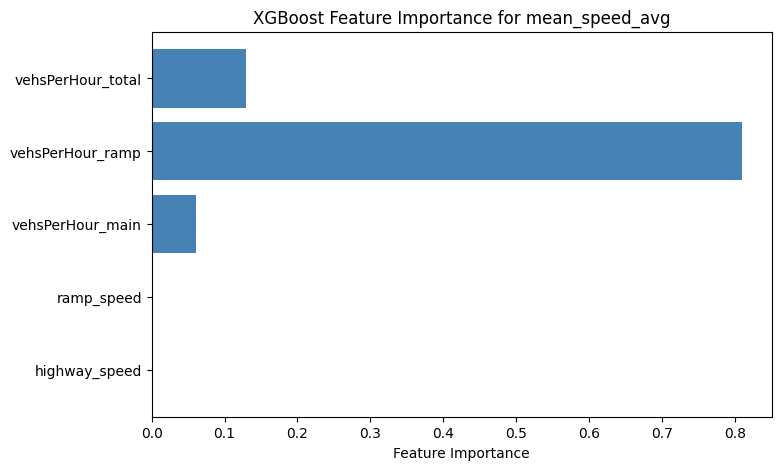

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42
)

# ===========================
# 4. Define and train XGBoost Regressor
# ===========================
model = XGBRegressor(
    n_estimators=300,       # number of trees
    learning_rate=0.05,     # step size
    max_depth=5,            # tree depth
    subsample=0.8,          # sample ratio
    colsample_bytree=0.8,   # feature ratio
    random_state=42
)

model.fit(X_train, y_train)

# ===========================
# 5. Evaluate the model
# ===========================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n✅ XGBoost Model Evaluation:")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

# ===========================
# 6. Predict for new parameters
# ===========================
new_data = pd.DataFrame([{
    "highway_speed": 33.33,       # m/s (≈120 km/h)
    "ramp_speed": 22.22,          # m/s (≈80 km/h)
    "vehsPerHour_main": 1800,
    "vehsPerHour_ramp": 600,
    "vehsPerHour_total": 2400
}])

predicted_speed = model.predict(new_data)[0]
print(f"\n🚗 Predicted mean_speed_avg: {predicted_speed:.2f} m/s")

# ===========================
# 7. Feature importance (optional)
# ===========================
import matplotlib.pyplot as plt
import numpy as np

importance = model.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(df.columns, importance, color="steelblue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance for mean_speed_avg")
plt.show()

In [12]:
params = {
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
}
grid = GridSearchCV(XGBRegressor(random_state=42), params, cv=5, scoring="r2", verbose=1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best R²:", grid.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best R²: 0.9902098904343715



✅ Random Forest Model Evaluation:
Mean Absolute Error: 0.103
Mean Squared Error: 0.025
R² Score: 0.985

🚗 Predicted mean_speed_avg: 21.57 m/s


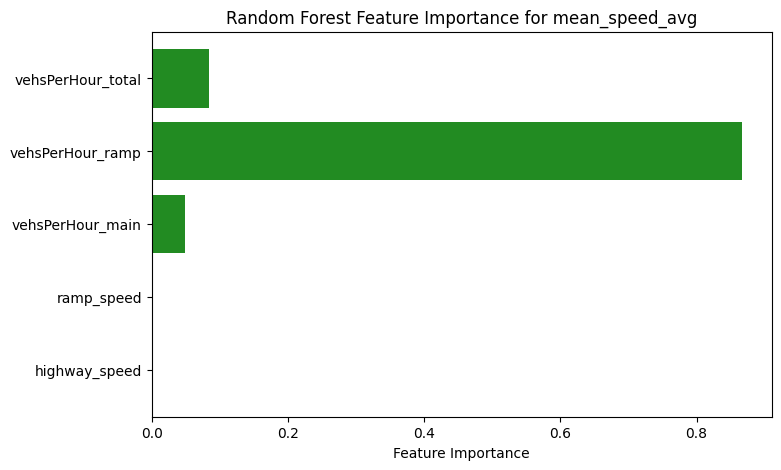

In [13]:
rf = RandomForestRegressor(
    n_estimators=200,       # number of trees
    max_depth=10,           # limit tree depth (None = unlimited)
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

rf.fit(X_train, y_train)

# ===========================
# 5. Evaluate model
# ===========================
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n✅ Random Forest Model Evaluation:")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

# ===========================
# 6. Predict for new parameters
# ===========================
new_data = pd.DataFrame([{
    "highway_speed": 33.33,       # 120 km/h
    "ramp_speed": 22.22,          # 80 km/h
    "vehsPerHour_main": 1800,
    "vehsPerHour_ramp": 600,
    "vehsPerHour_total": 2400
}])

predicted_speed = rf.predict(new_data)[0]
print(f"\n🚗 Predicted mean_speed_avg: {predicted_speed:.2f} m/s")

# ===========================
# 7. Feature importance plot
# ===========================
importances = rf.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(df.columns, importances, color="forestgreen")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance for mean_speed_avg")
plt.show()



In [14]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1
)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best R²:", grid.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best R²: 0.9823668171341262


In [15]:
print(y_test[:10],rf.predict(X_test)[:10])

140    19.472900
397    21.337884
6      20.616024
334    20.168376
322    18.710933
82     20.070769
225    20.724436
495    19.715656
522    21.334733
101    20.065276
Name: meanSpeed_avg, dtype: float64 [19.32111785 21.40061116 20.68551065 20.30942783 18.60295368 20.130596
 20.60364889 19.7951383  21.25161228 20.03059419]


0:	learn: 1.1575019	test: 1.2214001	best: 1.2214001 (0)	total: 46.7ms	remaining: 23.3s
100:	learn: 0.1286632	test: 0.1813079	best: 0.1813079 (100)	total: 84ms	remaining: 332ms
200:	learn: 0.0840175	test: 0.1300347	best: 0.1299559 (198)	total: 121ms	remaining: 179ms
300:	learn: 0.0708472	test: 0.1225026	best: 0.1225026 (300)	total: 159ms	remaining: 105ms
400:	learn: 0.0623856	test: 0.1193829	best: 0.1193753 (394)	total: 198ms	remaining: 48.8ms
499:	learn: 0.0559004	test: 0.1167261	best: 0.1167189 (498)	total: 233ms	remaining: 0us

bestTest = 0.1167189383
bestIteration = 498

Shrink model to first 499 iterations.

✅ CatBoost Model Evaluation:
Mean Absolute Error: 0.086
Mean Squared Error: 0.014
R² Score: 0.992

🚗 Predicted mean_speed_avg: 21.52 m/s


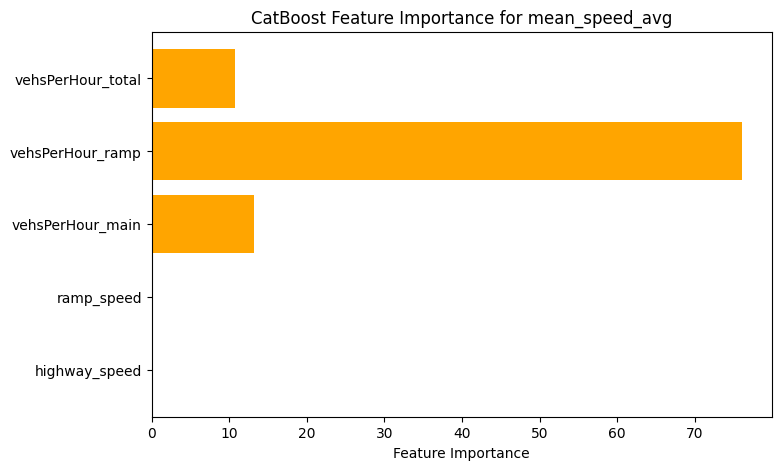

In [16]:
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# ===========================
# 5. Evaluate model
# ===========================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n✅ CatBoost Model Evaluation:")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

# ===========================
# 6. Predict for new parameters
# ===========================
new_data = pd.DataFrame([{
    "highway_speed": 33.33,       # 120 km/h
    "ramp_speed": 22.22,          # 80 km/h
    "vehsPerHour_main": 1800,
    "vehsPerHour_ramp": 600,
    "vehsPerHour_total": 2400
}])

predicted_speed = model.predict(new_data)[0]
print(f"\n🚗 Predicted mean_speed_avg: {predicted_speed:.2f} m/s")

# ===========================
# 7. Feature importance plot
# ===========================
importances = model.get_feature_importance()
plt.figure(figsize=(8,5))
plt.barh(df.columns, importances, color='orange')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance for mean_speed_avg")
plt.show()

Iteration 1, loss = 204.46501416
Validation score: -375.748272
Iteration 2, loss = 202.96863368
Validation score: -372.856567
Iteration 3, loss = 201.48477197
Validation score: -369.964581
Iteration 4, loss = 200.04630289
Validation score: -367.104699
Iteration 5, loss = 198.58918578
Validation score: -364.233558
Iteration 6, loss = 197.11279944
Validation score: -361.318147
Iteration 7, loss = 195.59987668
Validation score: -358.321249
Iteration 8, loss = 194.05758931
Validation score: -355.252690
Iteration 9, loss = 192.44365344
Validation score: -352.124641
Iteration 10, loss = 190.79559782
Validation score: -348.894705
Iteration 11, loss = 189.11017217
Validation score: -345.541221
Iteration 12, loss = 187.33928774
Validation score: -342.047133
Iteration 13, loss = 185.51388024
Validation score: -338.395878
Iteration 14, loss = 183.62238574
Validation score: -334.604986
Iteration 15, loss = 181.65442255
Validation score: -330.667135
Iteration 16, loss = 179.61024675
Validation scor

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


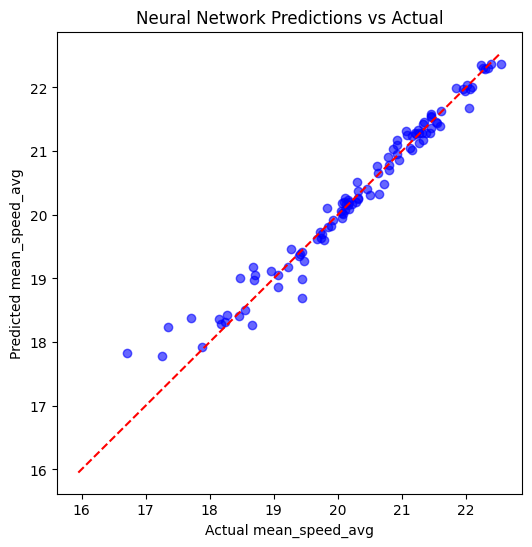

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42
)

# ===========================
# 4. Scale features (important for NN)
# ===========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===========================
# 5. Define Neural Network model
# ===========================
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # two hidden layers
    activation='relu',            # common choice
    solver='adam',                # optimizer
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,          # stop if no improvement on validation
    n_iter_no_change=50,
    verbose=True
)

# Train the model
mlp.fit(X_train_scaled, y_train)

# ===========================
# 6. Evaluate model
# ===========================
y_pred = mlp.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n✅ Neural Network Model Evaluation:")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

# ===========================
# 7. Predict for new parameters
# ===========================
new_data = pd.DataFrame([{
    "highway_speed": 33.33,       # 120 km/h
    "ramp_speed": 22.22,          # 80 km/h
    "vehsPerHour_main": 1800,
    "vehsPerHour_ramp": 600,
    "vehsPerHour_total": 2400
}])

new_data_scaled = scaler.transform(new_data)
predicted_speed = mlp.predict(new_data_scaled)[0]
print(f"\n🚗 Predicted mean_speed_avg: {predicted_speed:.2f} m/s")

# ===========================
# 8. Plot predicted vs actual
# ===========================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual mean_speed_avg")
plt.ylabel("Predicted mean_speed_avg")
plt.title("Neural Network Predictions vs Actual")
plt.show()